In [1]:
import pandas as pd
import re
import os

# Process for descriptive analysis

In [2]:
import pandas as pd
import os

# === Step 1: Load raw data ===
file_path = "output/final_merged_income_automation_2015_2024.xlsx"
df = pd.read_excel(file_path)

# === Step 2: Convert numeric columns (without dropping yet) ===
df["Context"] = pd.to_numeric(df["Context"], errors="coerce")
df["Job Zone"] = pd.to_numeric(df["Job Zone"], errors="coerce")
df["total_median_weekly_earnings"] = pd.to_numeric(df["total_median_weekly_earnings"], errors="coerce")

# === Step 3: Rename for consistency ===
df = df.rename(columns={
    "Context": "automation_score",
    "Job Zone": "job_zone",
    "total_median_weekly_earnings": "weekly_earnings"
})

# === Step 4: Save minimally cleaned data for flexible use ===
save_dir = "output/4_CPS"
os.makedirs(save_dir, exist_ok=True)
output_path = os.path.join(save_dir, "1_processed_for_analysis.xlsx")
df.to_excel(output_path, index=False)

print(f"✅ Raw processed dataset saved with shape: {df.shape}")
print(df[["Occupation", "Code", "automation_score", "job_zone", "weekly_earnings"]].head())
print(f"✅ Saved to: {output_path}")

✅ Raw processed dataset saved with shape: (7975, 39)
         Occupation        Code  automation_score  job_zone  weekly_earnings
0  Chief Executives  11-1011.00              31.0       5.0           2041.0
1  Chief Executives  11-1011.00              31.0       5.0           2303.0
2  Chief Executives  11-1011.00              31.0       5.0           2296.0
3  Chief Executives  11-1011.00              31.0       5.0           2291.0
4  Chief Executives  11-1011.00              31.0       5.0           2380.0
✅ Saved to: output/4_CPS/1_processed_for_analysis.xlsx


### summary_main_category_from_data

In [3]:
# import pandas as pd
# import os

# # === Step 1: Load cleaned dataset ===
# file_path = "output/4_CPS/1_processed_for_analysis.xlsx"
# df = pd.read_excel(file_path)

# # === Step 2: Generate the summary table ===
# category_summary = (
#     df.groupby("main_category")["Occupation"]
#     .nunique()
#     .reset_index(name="Unique Occupations")
# )

# # Calculate percentage of total
# total = category_summary["Unique Occupations"].sum()
# category_summary["% of Total"] = (category_summary["Unique Occupations"] / total * 100).round(2).astype(str) + "%"

# # === Step 3: Export the summary table ===
# output_dir = "output/4_CPS"
# os.makedirs(output_dir, exist_ok=True)
# output_path = os.path.join(output_dir, "summary_main_category_from_data.xlsx")
# category_summary.to_excel(output_path, index=False)

# # === Step 4: Report ===
# print(f"✅ Table generated and saved to: {output_path}")

# Descriptive Analysis

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Step 1: Load Data ===
df = pd.read_excel("output/4_CPS/1_processed_for_analysis.xlsx")

# === Step 2: Clean and rename relevant columns ===
df = df.rename(columns={
    "percent_of_total_employed_white_race": "White (%)",
    "percent_of_total_employed_black_or_african_american_race": "Black (%)",
    "percent_of_total_employed_asian_race": "Asian (%)",
    "percent_of_total_employed_hispanic_or_latino_race": "Hispanic (%)",
    "percent_of_total_employed_women_race": "% Women",
    "weekly_earnings": "Weekly Earnings",
    "automation_score": "Automation Score",
    "job_zone": "Job Zone"
})

# === Step 3: Remove broad occupation categories like “total” or “occupations” ===
df = df[~df["Occupation"].str.lower().str.contains("total|occupations", na=False)]

# === Step 4: Convert numeric fields ===
race_cols = ["White (%)", "Black (%)", "Asian (%)", "Hispanic (%)"]
num_cols = race_cols + ["% Women", "Weekly Earnings", "Automation Score", "Job Zone"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# === Step 5: Binning variables ===
df["Automation Risk"] = pd.qcut(df["Automation Score"], q=3, labels=["Low", "Medium", "High"])
df["Wage Group"] = pd.qcut(df["Weekly Earnings"], q=[0, 0.1, 0.9, 1], labels=["Bottom 10%", "Middle 80%", "Top 10%"])
df["Gender"] = df["% Women"].apply(lambda x: "Female" if x >= 50 else "Male")

# === Output directory ===
output_dir = "output/4_CPS"
os.makedirs(output_dir, exist_ok=True)

# === Helper function ===
def print_main_category_summary(title, df_subset):
    count = len(df_subset)
    print(f"\n✅ {title}: {count} rows")
    if "main_category" in df_subset.columns:
        summary = df_subset["main_category"].value_counts(dropna=False)
        percentage = (summary / count * 100).round(2)
        print("Main Category Distribution (% of this subset):")
        print((summary.astype(str) + " (" + percentage.astype(str) + "%)").to_string())

# # === Graph 1: Race Composition by Automation Risk ===
# df_race = df.dropna(subset=race_cols + ["Automation Risk"])
# print_main_category_summary("Graph 1 — Race by Automation Risk", df_race)

# race_avg = df_race.groupby("Automation Risk")[race_cols].mean().reset_index()
# race_long = race_avg.melt(id_vars="Automation Risk", var_name="Race", value_name="Average Percentage")
# sns.barplot(data=race_long, x="Race", y="Average Percentage", hue="Automation Risk")
# plt.title("Average Racial/Ethnic Composition Across Automation Risk Groups")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig(f"{output_dir}/plot1_race_by_risk.png")
# plt.close()
# race_long.to_excel(f"{output_dir}/table1_race_by_risk.xlsx", index=False)

# === Graph 2: Weekly Earnings by Gender and Risk ===
df_gender = df.dropna(subset=["Weekly Earnings", "% Women", "Automation Risk"])
print_main_category_summary("Graph 2 — Earnings by Gender and Risk", df_gender)

sns.boxplot(data=df_gender, x="Automation Risk", y="Weekly Earnings", hue="Gender")
plt.title("Box Plot of Weekly Earnings by Gender across Automation Risk Levels")
plt.tight_layout()
plt.savefig(f"{output_dir}/plot2_earnings_by_gender.png")
plt.close()
df_gender[["Occupation", "Weekly Earnings", "Gender", "Automation Risk"]].to_excel(
    f"{output_dir}/table2_earnings_by_gender_and_risk.xlsx", index=False
)

# === Graph 3: Heatmap of Job Zone Distribution ===
df_heatmap = df.dropna(subset=["Automation Risk", "Job Zone"])
print_main_category_summary("Graph 3 — Heatmap Job Zone by Risk", df_heatmap)

jobzone_dist = df_heatmap.groupby(["Automation Risk", "Job Zone"]).size().unstack(fill_value=0)
sns.heatmap(jobzone_dist, annot=True, fmt="d", cmap="Blues")
plt.title("Job Zone Distribution by Automation Risk")
plt.xlabel("Job Zone")
plt.ylabel("Automation Risk")
plt.tight_layout()
plt.savefig(f"{output_dir}/plot3_heatmap_jobzone_vs_risk.png")
plt.close()
jobzone_dist.to_excel(f"{output_dir}/table3_jobzone_vs_risk.xlsx")

# # === Graph 4: Bar Plot — Demographics & AI Exposure Distribution by Wage Group ===
# df_bar = df[df["Wage Group"].isin(["Top 10%", "Bottom 10%"])].copy()
# df_bar = df_bar.dropna(subset=["% Women", "Black (%)", "Asian (%)", "Hispanic (%)", "White (%)", "Automation Score"])

# bar_data = df_bar.groupby("Wage Group")[["% Women", "Black (%)", "Asian (%)", "Hispanic (%)", "White (%)", "Automation Score"]].mean().reset_index()
# bar_data_long = bar_data.melt(id_vars="Wage Group", var_name="Variable", value_name="Average Value")

# plt.figure(figsize=(12, 6))
# sns.barplot(data=bar_data_long, x="Variable", y="Average Value", hue="Wage Group")
# plt.title("Average Demographic Composition and Automation Exposure\nTop vs. Bottom 10% Wage Occupations")
# plt.xticks(rotation=25)
# plt.tight_layout()
# plt.savefig(f"{output_dir}/plot4_bar_top_bottom10.png")
# plt.close()
# bar_data_long.to_excel(f"{output_dir}/table4_bar_top_bottom10.xlsx", index=False)

# === Graph 4: Bar Plot — Demographics & AI Exposure Distribution by Wage Group ===
df_bar = df[df["Wage Group"].isin(["Top 10%", "Bottom 10%"])].copy()
df_bar = df_bar.dropna(subset=["% Women", "Black (%)", "Asian (%)", "Hispanic (%)", "White (%)", "Automation Score"])

bar_data = df_bar.groupby("Wage Group")[["% Women", "Black (%)", "Asian (%)", "Hispanic (%)", "White (%)", "Automation Score"]].mean().reset_index()
bar_data_long = bar_data.melt(id_vars="Wage Group", var_name="Variable", value_name="Average Value")

plt.figure(figsize=(12, 6))
sns.barplot(data=bar_data_long, x="Variable", y="Average Value", hue="Wage Group")
plt.title("Average Demographic Composition and Automation Exposure\nTop vs. Bottom 10% Wage Occupations")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig(f"{output_dir}/plot4_bar_top_bottom10.png")
plt.close()
bar_data_long.to_excel(f"{output_dir}/table4_bar_top_bottom10.xlsx", index=False)



print("\n✅ All four graphs and their data tables are saved in 'output/4_CPS/'")


✅ Graph 2 — Earnings by Gender and Risk: 2768 rows
Main Category Distribution (% of this subset):
main_category
Management, professional, and related occupations               1517 (54.8%)
Sales and office occupations                                    409 (14.78%)
Service occupations                                             364 (13.15%)
Natural resources, construction, and maintenance occupations     243 (8.78%)
Production, transportation, and material moving occupations      235 (8.49%)

✅ Graph 3 — Heatmap Job Zone by Risk: 5562 rows
Main Category Distribution (% of this subset):
main_category
Management, professional, and related occupations               2205 (39.64%)
NaN                                                              822 (14.78%)
Production, transportation, and material moving occupations      745 (13.39%)
Sales and office occupations                                     630 (11.33%)
Natural resources, construction, and maintenance occupations     625 (11.24%)
Se

/var/folders/cj/742s04b178ld3v0xjpn8xzt80000gn/T/ipykernel_26182/956105202.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  jobzone_dist = df_heatmap.groupby(["Automation Risk", "Job Zone"]).size().unstack(fill_value=0)
/var/folders/cj/742s04b178ld3v0xjpn8xzt80000gn/T/ipykernel_26182/956105202.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bar_data = df_bar.groupby("Wage Group")[["% Women", "Black (%)", "Asian (%)", "Hispanic (%)", "White (%)", "Automation Score"]].mean().reset_index()


/var/folders/cj/742s04b178ld3v0xjpn8xzt80000gn/T/ipykernel_26182/2881935351.py:35: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_latest["Dominant Race"] = df_latest[race_cols].idxmax(axis=1).str.replace(" (%)", "")


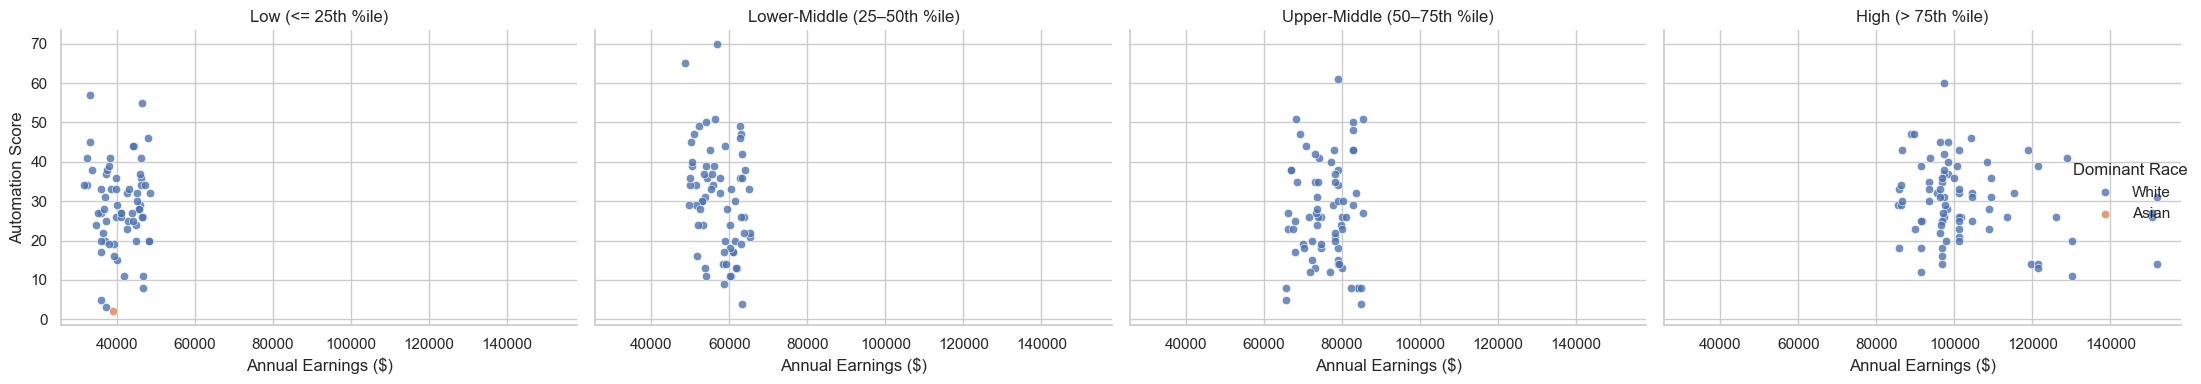

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Step 1: Load Data ===
df = pd.read_excel("output/4_CPS/1_processed_for_analysis.xlsx")

# === Step 2: Rename relevant columns ===
df = df.rename(columns={
    "percent_of_total_employed_white_race": "White (%)",
    "percent_of_total_employed_black_or_african_american_race": "Black (%)",
    "percent_of_total_employed_asian_race": "Asian (%)",
    "percent_of_total_employed_hispanic_or_latino_race": "Hispanic (%)",
    "weekly_earnings": "Weekly Earnings",
    "automation_score": "Automation Score",
    "year": "Year"
})

# === Step 3: Clean and preprocess ===
df = df[~df["Occupation"].str.lower().str.contains("total|occupations", na=False)]
df["Automation Score"] = pd.to_numeric(df["Automation Score"], errors="coerce")
df["Weekly Earnings"] = pd.to_numeric(df["Weekly Earnings"], errors="coerce")
df["Annual Earnings"] = df["Weekly Earnings"] * 52
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

race_cols = ["White (%)", "Black (%)", "Asian (%)", "Hispanic (%)"]
df[race_cols] = df[race_cols].apply(pd.to_numeric, errors="coerce")

# === Step 4: Filter to latest year ===
latest_year = df["Year"].max()
df_latest = df[df["Year"] == latest_year].copy()

# === Step 5: Assign dominant race ===
df_latest["Dominant Race"] = df_latest[race_cols].idxmax(axis=1).str.replace(" (%)", "")

# === Step 6: Assign wage quantile group ===
q25, q50, q75 = df_latest["Annual Earnings"].quantile([0.25, 0.5, 0.75])
def get_wage_group(val):
    if val <= q25:
        return "Low (<= 25th %ile)"
    elif val <= q50:
        return "Lower-Middle (25–50th %ile)"
    elif val <= q75:
        return "Upper-Middle (50–75th %ile)"
    else:
        return "High (> 75th %ile)"
df_latest["Wage Group"] = df_latest["Annual Earnings"].apply(get_wage_group)

# === Step 7: Create output dir ===
output_dir = "output/4_CPS"
os.makedirs(output_dir, exist_ok=True)

# === Step 8: Plot ===
sns.set(style="whitegrid")
g = sns.FacetGrid(
    df_latest,
    col="Wage Group",
    hue="Dominant Race",
    height=4,
    aspect=1.3,
    col_order=["Low (<= 25th %ile)", "Lower-Middle (25–50th %ile)", "Upper-Middle (50–75th %ile)", "High (> 75th %ile)"]
)
g.map_dataframe(
    sns.scatterplot,
    x="Annual Earnings",
    y="Automation Score",
    alpha=0.8
)
g.set_axis_labels("Annual Earnings ($)", "Automation Score")
g.set_titles("{col_name}")
g.add_legend()
plt.tight_layout()

# === Step 9: Save ===
plt.savefig(f"{output_dir}/scatter_dominant_race_by_wage_group.png")
plt.show()

In [26]:
import pandas as pd

# Load your dataset
df = pd.read_excel("output/4_CPS/1_processed_for_analysis.xlsx")

# === Step 3: Remove broad occupation categories like “total” or “occupations” ===
df = df[~df["Occupation"].str.lower().str.contains("total|occupations", na=False)]


# Make sure 'automation_score' is numeric
df['automation_score'] = pd.to_numeric(df['automation_score'], errors='coerce')

# Drop missing automation_score values
df = df.dropna(subset=['automation_score'])

# Calculate the quantiles
low_threshold = df['automation_score'].quantile(0.33)
medium_threshold = df['automation_score'].quantile(0.66)

# Print the thresholds
print(f"Low-High Thresholds for Automation Score:")
print(f" - Low/Medium cutoff (33rd percentile): {low_threshold:.2f}")
print(f" - Medium/High cutoff (66th percentile): {medium_threshold:.2f}")

# Optional: Also print min and max for reference
print(f"\nMin automation score: {df['automation_score'].min():.2f}")
print(f"Max automation score: {df['automation_score'].max():.2f}")

Low-High Thresholds for Automation Score:
 - Low/Medium cutoff (33rd percentile): 23.00
 - Medium/High cutoff (66th percentile): 33.00

Min automation score: 1.00
Max automation score: 70.00


race

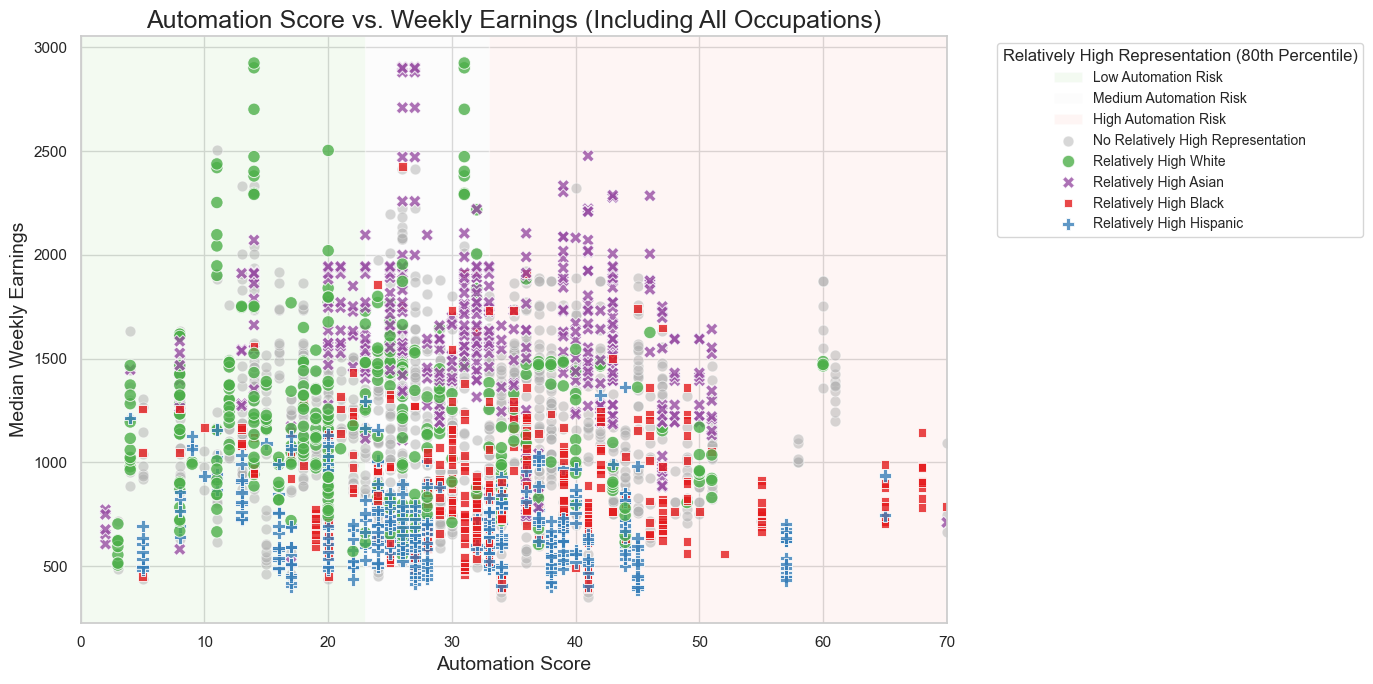

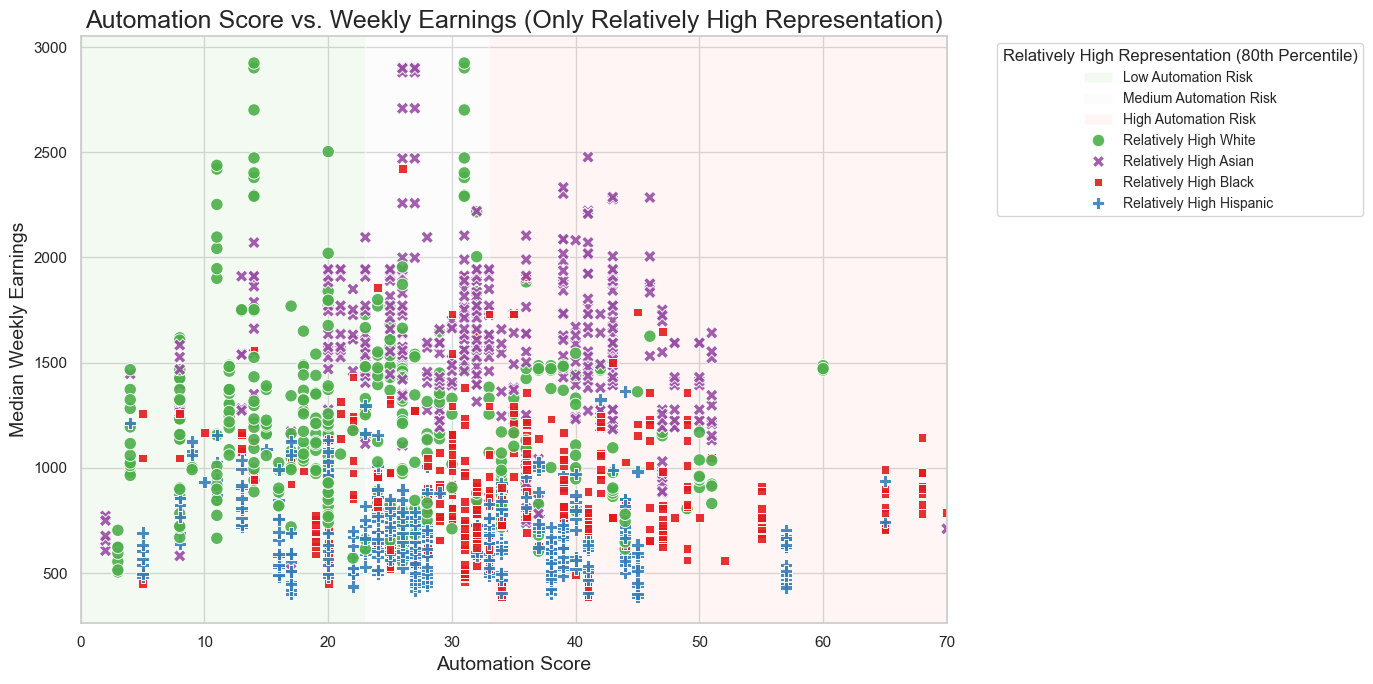

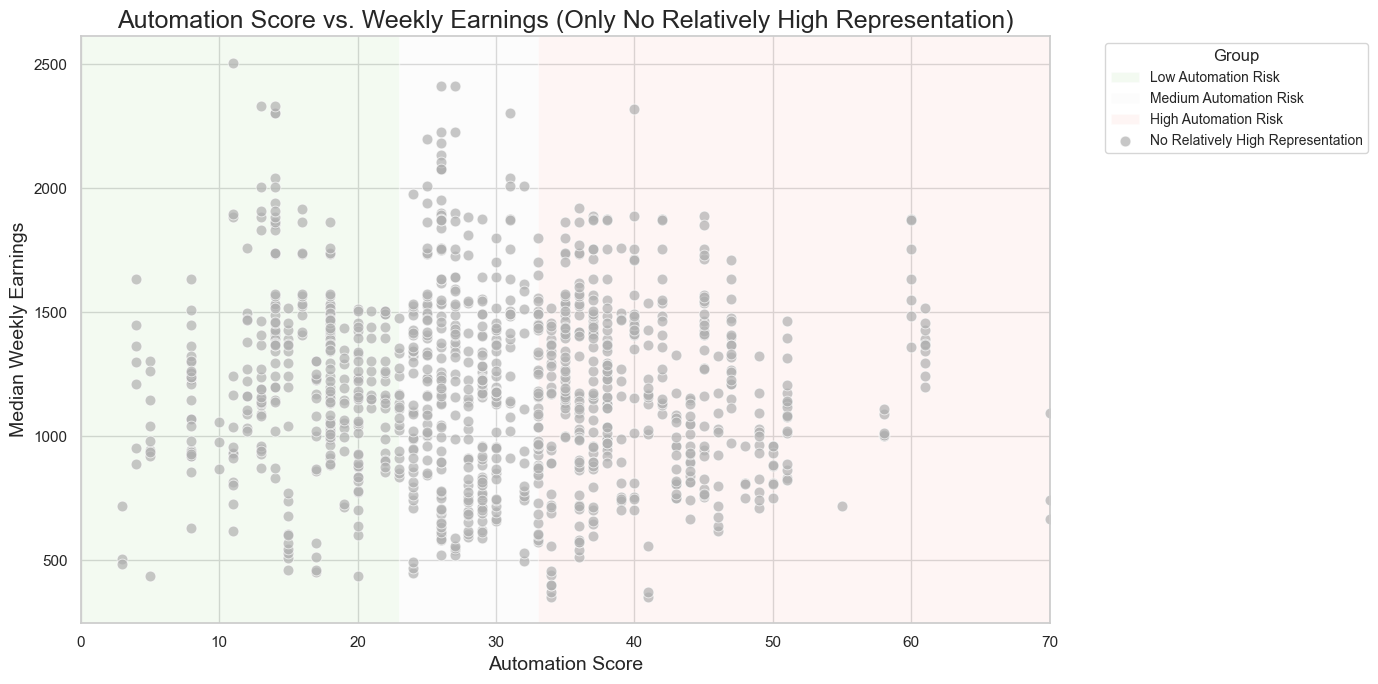

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load your processed dataset
df = pd.read_excel("output/4_CPS/1_processed_for_analysis.xlsx")

# === Step 3: Remove broad occupation categories like “total” or “occupations” ===
df = df[~df["Occupation"].str.lower().str.contains("total|occupations", na=False)]


# Step 1: Columns to use for racial percentages
race_cols = [
    'percent_of_total_employed_black_or_african_american_race',
    'percent_of_total_employed_hispanic_or_latino_race',
    'percent_of_total_employed_white_race',
    'percent_of_total_employed_asian_race'
]

# Step 2: Remove broad occupation categories like “total” or “occupations”
df = df[~df["Occupation"].str.lower().str.contains("total|occupations", na=False)]

# Step 3: Make sure race columns are numeric
for col in race_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 4: Calculate 80th percentile thresholds
black_q80 = df['percent_of_total_employed_black_or_african_american_race'].quantile(0.80)
hispanic_q80 = df['percent_of_total_employed_hispanic_or_latino_race'].quantile(0.80)
white_q80 = df['percent_of_total_employed_white_race'].quantile(0.80)
asian_q80 = df['percent_of_total_employed_asian_race'].quantile(0.80)

# Step 5: Label the relatively high representation group
def label_race(row):
    values = {
        'Relatively High Black': row['percent_of_total_employed_black_or_african_american_race'],
        'Relatively High Hispanic': row['percent_of_total_employed_hispanic_or_latino_race'],
        'Relatively High White': row['percent_of_total_employed_white_race'],
        'Relatively High Asian': row['percent_of_total_employed_asian_race']
    }
    qualified = {
        race: val for race, val in values.items()
        if (race == 'Relatively High Black' and val > black_q80) or
           (race == 'Relatively High Hispanic' and val > hispanic_q80) or
           (race == 'Relatively High White' and val > white_q80) or
           (race == 'Relatively High Asian' and val > asian_q80)
    }
    if not qualified:
        return 'No Relatively High Representation'
    return max(qualified, key=qualified.get)

df['relatively_high_race'] = df.apply(label_race, axis=1)

# Step 6: Split the dataset
df_none = df[df['relatively_high_race'] == 'No Relatively High Representation']
df_highlighted = df[df['relatively_high_race'] != 'No Relatively High Representation']

# Step 7: Define a custom color palette
custom_palette = {
    'Relatively High Black': '#e41a1c',      # Red
    'Relatively High Hispanic': '#377eb8',   # Blue
    'Relatively High White': '#4daf4a',      # Green
    'Relatively High Asian': '#984ea3'        # Purple
}

# Make sure output folder exists
output_folder = "output/4_CPS"
os.makedirs(output_folder, exist_ok=True)

# === Utility: Add background shading ===
def add_background(ax):
    ax.axvspan(0, 23, facecolor='#d9f0d3', alpha=0.3, label='Low Automation Risk')
    ax.axvspan(23, 33, facecolor='#f7f7f7', alpha=0.3, label='Medium Automation Risk')
    ax.axvspan(33, 70, facecolor='#fde0dd', alpha=0.3, label='High Automation Risk')

# Step 8: Plot 1 - All occupations
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Add background color
add_background(ax)

# Background: None group
sns.scatterplot(
    data=df_none,
    x='automation_score',
    y='weekly_earnings',
    color='#b0b0b0',
    label='No Relatively High Representation',
    marker='o',
    s=60,
    alpha=0.5
)

# Foreground: Highlighted groups
sns.scatterplot(
    data=df_highlighted,
    x='automation_score',
    y='weekly_earnings',
    hue='relatively_high_race',
    palette=custom_palette,
    style='relatively_high_race',
    markers=True,
    s=80,
    alpha=0.8
)

plt.title('Automation Score vs. Weekly Earnings (Including All Occupations)', fontsize=18)
plt.xlabel('Automation Score', fontsize=14)
plt.ylabel('Median Weekly Earnings', fontsize=14)
plt.xlim(0, 70)

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Relatively High Representation (80th Percentile)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

plt.grid(True)
plt.tight_layout()

# Save Plot 1
plt.savefig(os.path.join(output_folder, "automation_vs_wage_all_occupations.png"), dpi=300)
plt.show()

# Step 9: Plot 2 - Only relatively high groups
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Add background color
add_background(ax)

sns.scatterplot(
    data=df_highlighted,
    x='automation_score',
    y='weekly_earnings',
    hue='relatively_high_race',
    palette=custom_palette,
    style='relatively_high_race',
    markers=True,
    s=80,
    alpha=0.9
)

plt.title('Automation Score vs. Weekly Earnings (Only Relatively High Representation)', fontsize=18)
plt.xlabel('Automation Score', fontsize=14)
plt.ylabel('Median Weekly Earnings', fontsize=14)
plt.xlim(0, 70)

plt.legend(title='Relatively High Representation (80th Percentile)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save Plot 2
plt.savefig(os.path.join(output_folder, "automation_vs_wage_only_high_groups.png"), dpi=300)
plt.show()

# Step 10: Plot 3 - Only "No Relatively High Representation" (grey dots)
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Add background color
add_background(ax)

sns.scatterplot(
    data=df_none,
    x='automation_score',
    y='weekly_earnings',
    color='#b0b0b0',
    marker='o',
    s=60,
    alpha=0.7,
    label='No Relatively High Representation'
)

plt.title('Automation Score vs. Weekly Earnings (Only No Relatively High Representation)', fontsize=18)
plt.xlabel('Automation Score', fontsize=14)
plt.ylabel('Median Weekly Earnings', fontsize=14)
plt.xlim(0, 70)

# Smaller legend
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save Plot 3
plt.savefig(os.path.join(output_folder, "automation_vs_wage_only_grey_dots.png"), dpi=300)
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 1: Load your data ===
df = pd.read_excel("output/4_CPS/1_processed_for_analysis.xlsx")
df_raw = pd.read_excel(file_path)

# === Step 3: Remove broad occupation categories like “total” or “occupations” ===
df = df[~df["Occupation"].str.lower().str.contains("total|occupations", na=False)]


# === Step 2: Remove broad occupation categories like “total” or “occupations” ===
df_filtered = df_raw[~df_raw["Occupation"].str.lower().str.contains("total|occupations", na=False)]

# === Step 3: Convert percentages to numeric ===
df_filtered["percent_of_total_employed_women_race"] = pd.to_numeric(df_filtered["percent_of_total_employed_women_race"], errors="coerce")
df_filtered["percent_of_total_employed_black_or_african_american_race"] = pd.to_numeric(df_filtered["percent_of_total_employed_black_or_african_american_race"], errors="coerce")
df_filtered["percent_of_total_employed_hispanic_or_latino_race"] = pd.to_numeric(df_filtered["percent_of_total_employed_hispanic_or_latino_race"], errors="coerce")
df_filtered["percent_of_total_employed_white_race"] = pd.to_numeric(df_filtered["percent_of_total_employed_white_race"], errors="coerce")

# === Step 4: Create % Men ===
df_filtered["% Men"] = 100 - df_filtered["percent_of_total_employed_women_race"]

# === Step 5: Select columns and calculate correlation ===
correlation_data = df_filtered[[
    "job_zone",
    "% Men",
    "percent_of_total_employed_women_race",
    "percent_of_total_employed_black_or_african_american_race",
    "percent_of_total_employed_hispanic_or_latino_race",
    "percent_of_total_employed_white_race"
]].apply(pd.to_numeric, errors="coerce")

correlation_matrix = correlation_data.corr().round(3)

# === Step 6: Rename for cleaner labels ===
renamed_corr = correlation_matrix.rename(columns={
    "% Men": "% Men",
    "percent_of_total_employed_women_race": "% Women",
    "percent_of_total_employed_black_or_african_american_race": "% Black",
    "percent_of_total_employed_hispanic_or_latino_race": "% Hispanic",
    "percent_of_total_employed_white_race": "% White"
}, index={
    "% Men": "% Men",
    "percent_of_total_employed_women_race": "% Women",
    "percent_of_total_employed_black_or_african_american_race": "% Black",
    "percent_of_total_employed_hispanic_or_latino_race": "% Hispanic",
    "percent_of_total_employed_white_race": "% White"
})

# === Step 7: Plot the heatmap ===
plt.figure(figsize=(7, 6))
sns.heatmap(renamed_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", cbar_kws={'shrink': 0.8})
plt.title("Correlation Between Demographics and Job Zone (with % Men)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'your_file_path_here.xlsx'